In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,new_tweet_length,original_tweet_length
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN,5,14
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND,5,11
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,19,27
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,6,11
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,8,12


# *** --changed

In [0]:
data = data[data['subtask_c'].isin(['IND'  , 'GRP' , 'OTH'])]
data.drop(columns=['subtask_a' , 'subtask_b'] , inplace = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_c
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,go home drink maga trump2020,3,2,1,1,IND
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,OTH
7,52415,@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used...,literally talk lol mass shoot like set up propaganda use divide us major issue like gun control terrorism,1,0,0,0,GRP
9,13384,@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #...,canada not need another cuck already enough looneyleft liberals f king great country qproofs trudeaumustgo,1,4,0,0,IND
12,28414,@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL,lie corrupt traitor nobody want hear anymore lie deepstatecorruption,1,1,1,0,IND


# Splitting Data: Train and Test


In [0]:
Y = data['subtask_c']
X = data.drop(['subtask_c','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (3876, 6)
Shape of Y:  (3876,)


In [0]:
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (2713, 6)
Shape of Y_train:  (2713,)
Shape of X_test:  (1163, 6)
Shape of Y_test:  (1163,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(IND=0, GRP=1 , OTH= 2))
Y_test = Y_test.map(dict(IND=0, GRP=1 , OTH = 2))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [0]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (2713, 1374)
Shape of X_test_tweet_bow  (1163, 1374)


##2. TF-IDF : Tweets

In [0]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (2713, 1374)
Shape of X_test_tweet_tfidf  (1163, 1374)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [0]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 1163/1163 [00:00<00:00, 28477.38it/s]


In [0]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (2713, 300)
Shape of X_test_tweet_avg_w2v_vectors  (1163, 300)


# Applying SVM on different featurization of Tweets

## 1. BOW



In [0]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_bow_svm =hstack((f1,f2,f3,f4,f5))
# pca = TruncatedSVD(n_components=100)

# reduced_train_bow_svm = pca.fit_transform(X_train_bow_svm)

In [0]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_bow_svm =hstack((f1,f2,f3,f4,f5))

# pca = TruncatedSVD(n_components=100)
# reduced_test_bow_svm = pca.fit_transform(X_test_bow_svm)


## Confusion Matrix: Linear SVC, SVC

### 1. LinearSVC  -> based on One vs rest approach ( n-1 classifiers )

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6070507308684436


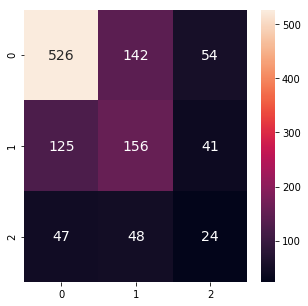

In [0]:
svm_bow = LinearSVC(class_weight='balanced')
svm_bow.fit(X_train_bow_svm,Y_train)
y_test_predict = svm_bow.predict(X_test_bow_svm)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'micro')))

#old f1: F1 Score = 0.63542562338779

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

457 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 
def prPurple(skk): print("\033[95m {}\033[00m" .format(skk)) 
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk)) 
def prLighBlue(skk): print("\033[94m {}\033[00m" .format(skk)) 
def prOrange(skk): print("\033[33m {}\033[00m" .format(skk)) 

Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER for your encore say that every other western country that’s all but eliminated mass shootings through effective gun control are lying too... it would be fitting
 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER @USER @USER have become the party of “the Sky is falling” and “we are all going to die”.  What a sad bunch.
 @USER @USER With Democrat's Sociability Quotient it's no wonder Democrats think about Gun Control all the time!
 @USER @USER Everything else was ten years ago. "  YOU ARE A LIAR, this is total BS propaganda from team Trump  his crimes were throughout the past decade, including up to 2016"
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 @USER @USER Liberals are using a sexual assault claim as a political tool. Let that sink in.
 @USER @USER MY FACE WAS SO CLOSE TO THE CONCRETE BITCH I COULDVE PROBABLY STUCK MY TONGUE OUT AND LICK IT
 @USER @USER stop this BS.  A woman murdered him in 

### 2. SVC -> based on one vs one approach  ( Working better than linearSVC)

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6741186586414445


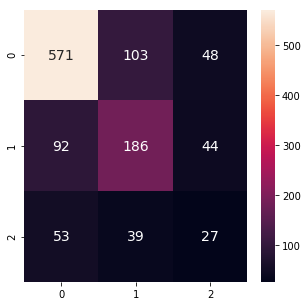

In [0]:
from sklearn.svm import SVC

## no other kernel is working better than default rbf
svm_bow = SVC(class_weight = 'balanced' , gamma='scale', decision_function_shape='ovo')
svm_bow.fit(X_train_bow_svm,Y_train)

y_test_predict = svm_bow.predict(X_test_bow_svm)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'micro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

379 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER for your encore say that every other western country that’s all but eliminated mass shootings through effective gun control are lying too... it would be fitting
 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER @USER @USER have become the party of “the Sky is falling” and “we are all going to die”.  What a sad bunch.
 @USER @USER With Democrat's Sociability Quotient it's no wonder Democrats think about Gun Control all the time!
 @USER UNTIL ITS YOUR ASS IN THE HOT SEAT  #WalkAway #WWG1WGA #PizzaGate #QAnon #Hivites #MAGA #EagleOneToWanta @USER @USER  .
 @USER I'm surprised he didn't shoot his students just prove gun control is important. I'm glad I don't send kids to college. What a waste of money turning them into pumpkin heads.
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 #joebiden calls Trump supporters dregs of society. #biden organized a coup in #ukraine. His son steals $B from ukrainian p

## 2. TF-IDF


In [0]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5))
X_train_tfidf.shape

(2713, 1378)

In [0]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_tfidf =hstack((f1,f2,f3,f4,f5))
X_test_tfidf.shape

(1163, 1378)

## Confusion Matrix : SVC, Linear SVC

### SVC -RBF Kernel

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.5958727429062769


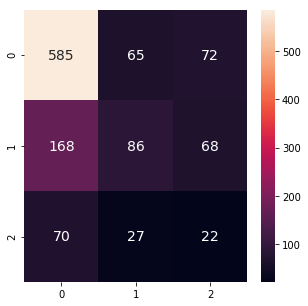

In [0]:
## no other kernel is working better than default rbf
svm_tfidf = SVC(class_weight = 'balanced' , gamma='scale', decision_function_shape='ovo')
svm_tfidf.fit(X_train_tfidf,Y_train)

y_test_predict = svm_tfidf.predict(X_test_tfidf)

results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'micro')))
#old F1 Score = 0.6165090283748925

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

470 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER for your encore say that every other western country that’s all but eliminated mass shootings through effective gun control are lying too... it would be fitting
 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER @USER @USER have become the party of “the Sky is falling” and “we are all going to die”.  What a sad bunch.
 @USER @USER With Democrat's Sociability Quotient it's no wonder Democrats think about Gun Control all the time!
 @USER Google CFO is a joke! And so is the idiot who hired her for this position.  #Googlearecorrupt   #BestuseQwant
 @USER UNTIL ITS YOUR ASS IN THE HOT SEAT  #WalkAway #WWG1WGA #PizzaGate #QAnon #Hivites #MAGA #EagleOneToWanta @USER @USER  .
 @USER I'm surprised he didn't shoot his students just prove gun control is important. I'm glad I don't send kids to college. What a waste of money turning them into pumpkin heads.
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 @USER

### LinearSVC

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.6362854686156492


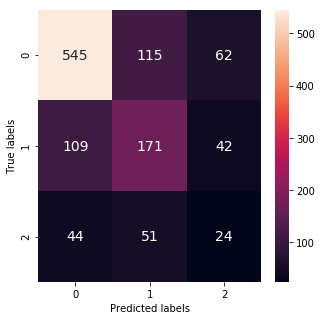

In [0]:
svm_tfidf = LinearSVC(class_weight='balanced')
svm_tfidf.fit(X_train_tfidf,Y_train)

y_test_predict = svm_tfidf.predict(X_test_tfidf)

results = confusion_matrix(Y_test, y_test_predict)

plt.figure(figsize = (5,5))
ax = sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict, average='micro')))

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

423 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 @USER @USER for your encore say that every other western country that’s all but eliminated mass shootings through effective gun control are lying too... it would be fitting
 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER With Democrat's Sociability Quotient it's no wonder Democrats think about Gun Control all the time!
 @USER @USER Everything else was ten years ago. "  YOU ARE A LIAR, this is total BS propaganda from team Trump  his crimes were throughout the past decade, including up to 2016"
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 @USER @USER And not all idiots grandstands like he did
 @USER @USER MY FACE WAS SO CLOSE TO THE CONCRETE BITCH I COULDVE PROBABLY STUCK MY TONGUE OUT AND LICK IT
 @USER @USER stop this BS.  A woman murdered him in his own home!  This is so incredibly irresponsible and I am outraged that you are blaming the victim who is a black man.  What does him having weed have anythi

# 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)

X_train_w2vec =hstack((f1,f2,f3,f4,f5))
X_train_w2vec.shape

(2713, 304)

In [0]:
f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)

X_test_w2vec =hstack((f1,f2,f3,f4,f5))
X_test_w2vec.shape

(1163, 304)

## Confusion Matrix: SVC, Linear SVC

### SVC

F1 Score = 0.5666380051590714


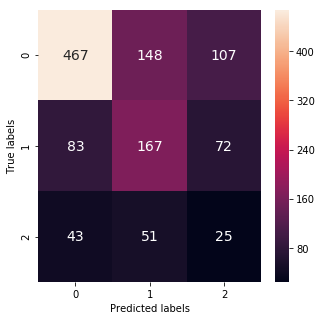

In [0]:
## RBF kernel
svm_w2vec =SVC(class_weight = 'balanced' , gamma='scale', decision_function_shape='ovo')
svm_w2vec.fit(X_train_w2vec,Y_train)

y_test_predict = svm_w2vec.predict(X_test_w2vec)

results = confusion_matrix(Y_test, y_test_predict)

plt.figure(figsize = (5,5))
ax = sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 


print("F1 Score = " + str(f1_score(Y_test,y_test_predict, average='micro')))
#F1 Score = 0.4829560050582302


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

504 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER Everything else was ten years ago. "  YOU ARE A LIAR, this is total BS propaganda from team Trump  his crimes were throughout the past decade, including up to 2016"
 @USER I'm surprised he didn't shoot his students just prove gun control is important. I'm glad I don't send kids to college. What a waste of money turning them into pumpkin heads.
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 @USER He is the absolute worse. Period. That is all.
 #joebiden calls Trump supporters dregs of society. #biden organized a coup in #ukraine. His son steals $B from ukrainian people as they leave their country in search of jobs. @USER #maga #potus @USER @USER #zog"
 @USER @USER It’s easier for Pod to believe both sides are terrible. Then he doesn’t have to honestly look at the conservatives.
 @USER @USER She is a Republican. Do you actually expect any different. And as far a

### Linear SVC

original size in test data : 
 0    722
1    322
2    119
Name: subtask_c, dtype: int64
F1 Score = 0.5932932072227


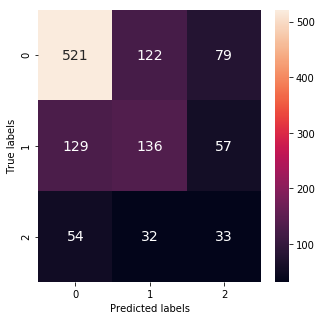

In [0]:
svm_w2vec = LinearSVC(class_weight='balanced')
svm_w2vec.fit(X_train_w2vec,Y_train)

y_test_predict = svm_w2vec.predict(X_test_w2vec)

results = confusion_matrix(Y_test, y_test_predict)

plt.figure(figsize = (5,5))
ax = sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 

print("original size in test data : \n" , Y_test.value_counts())
print("F1 Score = " + str(f1_score(Y_test,y_test_predict, average='micro')))
#F1 Score = 0.46850752834157045

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

473 misclassifications


Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
#IND=0, GRP=1 , OTH= 2
for index in misclassified[0]:
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and y_test_predict[index] == 2:
    prGreen(X_test.iloc[index,0])
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prPurple(X_test.iloc[index,0])
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and y_test_predict[index] == 2:
    prCyan(X_test.iloc[index,0])
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and y_test_predict[index] == 0:
    prLighBlue(X_test.iloc[index,0])
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and y_test_predict[index] == 1:
    prOrange(X_test.iloc[index,0])


 Anyone surprised? @USER  #CloserNation  #MAGA #QAnon URL
 @USER @USER With Democrat's Sociability Quotient it's no wonder Democrats think about Gun Control all the time!
 @USER I'm surprised he didn't shoot his students just prove gun control is important. I'm glad I don't send kids to college. What a waste of money turning them into pumpkin heads.
 @USER Any Texan that would grant automatic citizenship to illegal immigrants should never be elected.
 @USER @USER And not all idiots grandstands like he did
 @USER @USER Liberals are using a sexual assault claim as a political tool. Let that sink in.
 @USER He is the absolute worse. Period. That is all.
 #joebiden calls Trump supporters dregs of society. #biden organized a coup in #ukraine. His son steals $B from ukrainian people as they leave their country in search of jobs. @USER #maga #potus @USER @USER #zog"
 @USER @USER You are name calling a decorated disabled veteran. - shame on you. Know your subject before making slanderous remar